# Organelle classification analysis
##### takes similarity matrix vs organelle marker genes to calculate where an orphan gene is most likely to localize
##### matrix contains localization similarity scores of orphan proteins and the whole OpenCell collection

##### similarity matrix from James Burgess, adapted from cytoself (Kobayashi et al. Nature Methods 2022)

In [1]:
import sys

print(sys.executable)

/Users/manuel.leonetti/miniconda3/envs/kibeom_env/bin/python


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
plt.rcParams['pdf.fonttype'] = 42



In [3]:
# load matrix of similarity scores and format to avoid plotting similarity of orphan proteins vs themselves 

similarity_scores_df = pd.read_csv('./tspan6_distmat_manualfilter_True__representation_vqvec2__rotations_False__mode_correlation__pcadim_200.csv', index_col=0)
similarity_scores_df = similarity_scores_df.iloc[42:]
similarity_scores_df.head()

,ANKRD46,C4orf3,CD151,CD276,CD99,CLMN,CMTM4,CMTM7,COMTD1,GLT8D1,...,YWHAH,YWHAQ,YWHAZ,YY1,ZCCHC17,ZCCHC7,ZCCHC9,ZNF326,ZNF598,ZYX
AAMP,-0.263323,-0.182323,-0.345822,-0.350912,-0.346413,-0.249297,-0.316369,-0.159799,-0.292195,-0.260935,...,0.825385,0.844812,0.675984,-0.260620,-0.180267,-0.257624,-0.270868,-0.155755,-0.076374,-0.302356
AATF,-0.052815,0.027725,-0.085427,-0.129017,-0.032868,0.143390,-0.062918,0.134126,0.059552,0.105051,...,-0.057853,-0.096269,-0.111649,0.194470,-0.030682,0.031529,0.089173,-0.035378,0.059228,0.094362
ABCE1,-0.292925,-0.216211,-0.315510,-0.360736,-0.350453,-0.239528,-0.326004,-0.176366,-0.287319,-0.264626,...,0.829507,0.860447,0.698224,-0.244978,-0.182497,-0.241852,-0.266468,-0.130220,-0.070030,-0.271204
ABR,-0.002938,-0.039004,-0.293707,-0.297258,-0.279041,-0.209273,-0.279174,-0.232012,-0.251301,-0.229905,...,0.188748,0.102793,0.014262,-0.206625,-0.190960,-0.240230,-0.213084,-0.103262,0.380680,-0.141395
ACAP2,0.035558,-0.050202,-0.202957,-0.265096,-0.290745,-0.236780,-0.261780,-0.256107,-0.330142,-0.216115,...,0.162127,0.016521,-0.060480,-0.157578,-0.158729,-0.277408,-0.179794,-0.088315,0.526513,-0.176761


In [4]:
# fix TSPAN6 naming; the correct column for it should actually be "well_H5_protein"

similarity_scores_df = similarity_scores_df.drop(columns=["TSPAN6"])
similarity_scores_df = similarity_scores_df.rename(columns={"well_H5_protein":"TSPAN6"})
similarity_scores_df.head()


,ANKRD46,C4orf3,CD151,CD276,CD99,CLMN,CMTM4,CMTM7,COMTD1,GLT8D1,...,YWHAH,YWHAQ,YWHAZ,YY1,ZCCHC17,ZCCHC7,ZCCHC9,ZNF326,ZNF598,ZYX
AAMP,-0.263323,-0.182323,-0.345822,-0.350912,-0.346413,-0.249297,-0.316369,-0.159799,-0.292195,-0.260935,...,0.825385,0.844812,0.675984,-0.260620,-0.180267,-0.257624,-0.270868,-0.155755,-0.076374,-0.302356
AATF,-0.052815,0.027725,-0.085427,-0.129017,-0.032868,0.143390,-0.062918,0.134126,0.059552,0.105051,...,-0.057853,-0.096269,-0.111649,0.194470,-0.030682,0.031529,0.089173,-0.035378,0.059228,0.094362
ABCE1,-0.292925,-0.216211,-0.315510,-0.360736,-0.350453,-0.239528,-0.326004,-0.176366,-0.287319,-0.264626,...,0.829507,0.860447,0.698224,-0.244978,-0.182497,-0.241852,-0.266468,-0.130220,-0.070030,-0.271204
ABR,-0.002938,-0.039004,-0.293707,-0.297258,-0.279041,-0.209273,-0.279174,-0.232012,-0.251301,-0.229905,...,0.188748,0.102793,0.014262,-0.206625,-0.190960,-0.240230,-0.213084,-0.103262,0.380680,-0.141395
ACAP2,0.035558,-0.050202,-0.202957,-0.265096,-0.290745,-0.236780,-0.261780,-0.256107,-0.330142,-0.216115,...,0.162127,0.016521,-0.060480,-0.157578,-0.158729,-0.277408,-0.179794,-0.088315,0.526513,-0.176761


In [5]:
# load knn data to define nearest neighbors in cystoself latent space

knn_num_df = pd.read_csv('./tspan6_knn_opencell_preds_manualfilter_True__representation_vqvec2__rotations_False__mode_correlation__pcadim_200.csv',
                         index_col=0, header=2)


knn_num_df = knn_num_df.drop(columns=["TSPAN6"])
knn_num_df = knn_num_df.rename(columns={"well_H5_protein":"TSPAN6"})

knn_num_df.head()


,ANKRD46,C4orf3,CD151,CD276,CD99,CLMN,CMTM4,CMTM7,COMTD1,GLT8D1,...,TPRA1,TSPAN3,TVP23C,ZZEF1,pML544,pML545,pML548,pML549,TSPAN6,well_H8_protein
protein,,,,,,,,,,,,,,,,,,,,,
orgIP_cluster_annotation,ER,ER,"ER, new analysis says plasma membrane",plasma membrane,plasma membrane,ER,recycling endosome,recycling endosome,mitochondrion,Golgi,...,ER,lysosome,trans-Golgi,endocytic plasma membrane,NaN,NaN,NaN,NaN,NaN,NaN
plate33_eyeballed_annotation,nice ER,nice ER,nice lysosome,"few cells, maybe some aggregates",negative,"dim ER, very few cells","plasma membrane, nice","nice, complex plasmam membrane + lysosome?","dim, maybe endo-lysosome","nucleolus, very few cells",...,NaN,nice lysosome,nice Golgi,cytoplasmic,NaN,NaN,NaN,NaN,NaN,NaN
prot_nn0,NAT14,ANKRD46,PIP4P1,MYO1C,SLC16A1,SVIL,CD276,pML545,PI4K2A,GNL3,...,TMEM184C,TSPAN6,MAN1A2,ZNF598,REEP4,CMTM7,MAPKAPK3,TAF12,CD81,RNF149
prot_nn1,ODR4,SEC61B,SLC2A1,CMTM4,MYO1C,SLC4A2,YES1,SLC16A10,SLC37A3,RRP1,...,CLCN7,TMEM184C,COMTD1,AKAP13,REEP3,SLC4A2,IPO8,RBM7,SPG21,CLMN
prot_nn2,C4orf32,EMC4,SLC16A2,SLC7A6,CD276,SLC16A10,PIP5K1A,SLC4A2,CLMN,NPM3,...,TSPAN3,TPRA1,ELOVL1,AGO1,pML545,SLC16A10,MAPK8,HSF1,CD9,ZCCHC7


In [6]:
# define list of orphan proteins

orphans = ['ANKRD46', 'C4orf3', 'SFT2D3', 'KLRG2', 'NAT14', 'ODR4',
         'CD276', 'TSPAN3', 'MFSD5', 'TP53I11', 'CD99', 'SUSD5',
         'TMEM245', 'TMEM41A', 'TMEM209', 'ZZEF1', 'KIAA1522',
         'MPZL1', 'TMEM184C', 'TVP23C', 'SFT2D2', 'CMTM4', 'SCAMP3',
         'CD151', 'SLC35F1', 'SLC35F2', 'CMTM7', 'SCAMP4', 'TSPAN6',
         'TPRA1', 'GLT8D1']



# organelle analysis of orphan proteins
 gois = ['ANKRD46', 
        'C4orf3', 
        'NAT14',
        'ODR4',
        'TP53I11',
        'TMEM245',
        'TMEM41A',
        'TMEM209',
        'SFT2D3', 
        'MFSD5',
        'TVP23C',
        'TPRA1',
        'GLT8D1',
        'KLRG2', 
        'CD276',
        'CD99',
        'SUSD5',
        'KIAA1522',
        'MPZL1',
        'SFT2D2',
        'CMTM4',
        'CD151',
        'TSPAN3',
        'TMEM184C',
        'TSPAN6',
        'SCAMP3',
        'ZZEF1']

In [7]:
# load Suppl Table 1: reference markers for individual organelles using literature-curated data

markers = pd.read_excel('./Supplementary_Table_1_literature-curated_organelle_ground-truth.xlsx', sheet_name='organelle_markers', index_col=0) 
markers.head()

,organelle,source,Note
gene_name_canonical,,,
ACTN1,actin-binding_protein,Itzhak et al 2016 PMID: 27278775,confidence score: high
ACTN4,actin-binding_protein,Itzhak et al 2016 PMID: 27278775,confidence score: high
COBL,actin-binding_protein,Itzhak et al 2016 PMID: 27278775,confidence score: very high
CORO1B,actin-binding_protein,Itzhak et al 2016 PMID: 27278775,confidence score: high
CORO2A,actin-binding_protein,Itzhak et al 2016 PMID: 27278775,confidence score: high


In [8]:
# define list of reference organelle markers also present in OpenCell, including classical nucleolar marker genes for GLT8D1 analysis
# outputs number of markers found in OpenCell


er_markers = markers[markers['organelle'] == 'ER'].index
ergic_markers =  markers[markers['organelle'] == 'ERGIC'].index
golgi_markers = markers[markers['organelle'] == 'Golgi'].index
lyso_markers = markers[markers['organelle'] == 'lysosome'].index
mito_markers = markers[markers['organelle'] == 'mitochondria'].index
pm_markers = markers[markers['organelle'] == 'plasma membrane'].index
ee_markers = markers[markers['organelle'] == 'early_endosome'].index
actin_markers = markers[markers['organelle'] == 'actin-binding_protein'].index
perox_markers =  markers[markers['organelle'] == 'peroxisome'].index
cytosol_markers = markers[markers['organelle'] == 'cytosol'].index
nucleus_markers = markers[markers['organelle'] == 'nucleus'].index
nuc_pore_markers = markers[markers['organelle'] == 'nuclear_pore'].index
nucleolus_marker_genes = ['GNL2', 'GNL3', 'NCL', 'NOL10', 'NOL11', 'NOM1', 'NOP53', 'NPM1', 'NPM3']

er_markers_in_OC = similarity_scores_df[similarity_scores_df.index.isin(er_markers)]
print('Num ER markers in OC:', len(er_markers_in_OC))
ergic_markers_in_OC = similarity_scores_df[similarity_scores_df.index.isin(ergic_markers)]
print('Num ERGIC markers in OC:', len(ergic_markers_in_OC))
golgi_markers_in_OC = similarity_scores_df[similarity_scores_df.index.isin(golgi_markers)]
print('Num Golgi markers in OC:', len(golgi_markers_in_OC))
lyso_markers_in_OC = similarity_scores_df[similarity_scores_df.index.isin(lyso_markers)]
print('Num lysosome markers in OC:', len(lyso_markers_in_OC))
mito_markers_in_OC = similarity_scores_df[similarity_scores_df.index.isin(mito_markers)]
print('Num mitochondria markers in OC:', len(mito_markers_in_OC))
pm_markers_in_OC = similarity_scores_df[similarity_scores_df.index.isin(pm_markers)]
print('Num PM markers in OC:', len(pm_markers_in_OC))
ee_markers_in_OC = similarity_scores_df[similarity_scores_df.index.isin(ee_markers)]
print('Num early endosome markers in OC:', len(ee_markers_in_OC))
actin_markers_in_OC = similarity_scores_df[similarity_scores_df.index.isin(actin_markers)]
print('Num actin markers in OC:', len(actin_markers_in_OC))
perox_markers_in_OC = similarity_scores_df[similarity_scores_df.index.isin(perox_markers)]
print('Num peroxisome markers in OC:', len(perox_markers_in_OC))
cytosol_markers_in_OC = similarity_scores_df[similarity_scores_df.index.isin(cytosol_markers)]
print('Num cytosol markers in OC:', len(cytosol_markers_in_OC))
nucleus_markers_in_OC = similarity_scores_df[similarity_scores_df.index.isin(nucleus_markers)]
print('Num nucleus markers in OC:', len(nucleus_markers_in_OC))
nucleolus_markers_in_OC = similarity_scores_df[similarity_scores_df.index.isin(nucleolus_marker_genes)]
print('Num nucleolus markers in OC:', len(nucleolus_markers_in_OC))
nuclear_pore_markers_in_OC = similarity_scores_df[similarity_scores_df.index.isin(nuc_pore_markers)]
print('Num nuclear pore markers in OC:', len(nuclear_pore_markers_in_OC))



Num ER markers in OC: 66
Num ERGIC markers in OC: 20
Num Golgi markers in OC: 2
Num lysosome markers in OC: 4
Num mitochondria markers in OC: 8
Num PM markers in OC: 39
Num early endosome markers in OC: 10
Num actin markers in OC: 13
Num peroxisome markers in OC: 1
Num cytosol markers in OC: 26
Num nucleus markers in OC: 47
Num nucleolus markers in OC: 9
Num nuclear pore markers in OC: 6


In [9]:
# sanity-check an example of marker list

actin_markers_in_OC.head()

,ANKRD46,C4orf3,CD151,CD276,CD99,CLMN,CMTM4,CMTM7,COMTD1,GLT8D1,...,YWHAH,YWHAQ,YWHAZ,YY1,ZCCHC17,ZCCHC7,ZCCHC9,ZNF326,ZNF598,ZYX
ACTN1,-0.069842,0.063666,0.129687,0.126064,0.115899,0.077658,0.109325,0.160698,0.243593,0.082961,...,-0.140502,-0.121545,0.055099,0.060027,0.136528,-0.003181,0.103753,0.199995,-0.219083,0.299736
ACTN4,-0.011941,0.093018,0.159432,0.365239,0.344547,0.021521,0.280857,0.233942,0.116493,0.097764,...,-0.171882,-0.130835,-0.086715,0.197630,0.113199,-0.003489,0.108581,0.138354,-0.260425,0.059173
CORO1B,-0.094426,-0.062762,0.307176,0.206310,0.211855,0.047091,0.248310,0.121006,0.024416,-0.096400,...,-0.226964,-0.168616,-0.061101,0.019826,0.013837,-0.052811,0.019192,0.105386,-0.180440,0.000333
CTTN,-0.041342,-0.001565,0.144387,0.107038,0.120973,-0.076562,0.128744,-0.083129,-0.029665,0.070220,...,-0.151205,-0.125870,-0.003955,0.011085,0.126787,0.012530,0.028466,0.179940,-0.137030,0.166764
DBNL,0.036025,0.075382,0.021531,0.047220,0.037847,0.046950,0.028699,0.049049,0.128000,0.008608,...,-0.120903,-0.103547,-0.020661,0.051020,0.164435,-0.003928,0.111934,0.131739,-0.167059,0.139881


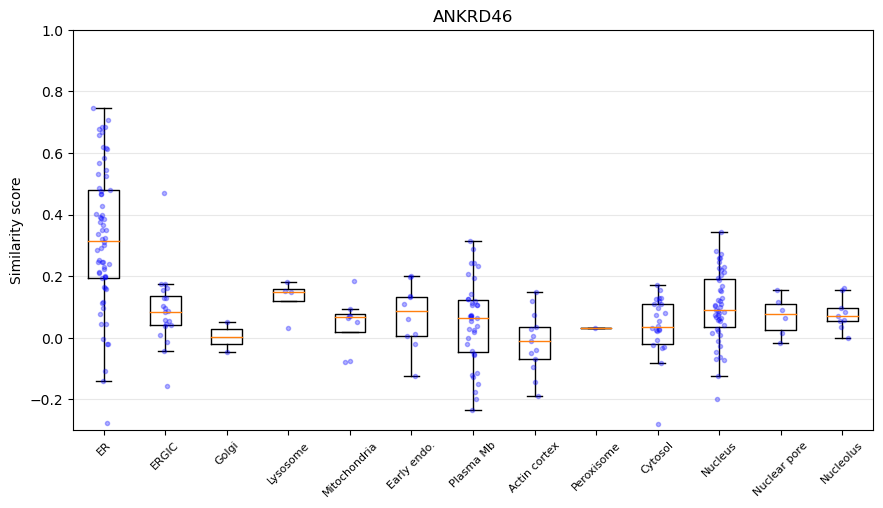

ANKRD46 nearest genes:
 NAT14 | score: 0.9376207974297083 | OC annot:  ORF 
 ODR4 | score: 0.8785008720094776 | OC annot:  ORF 
 C4orf32 | score: 0.8222811683343549 | OC annot:  er 
 TMEM208 | score: 0.8146864030006423 | OC annot:  er 
 EMC8 | score: 0.7580737438466164 | OC annot:  er 
 CERS5 | score: 0.7473037767185666 | OC annot:  er 
 CERS6 | score: 0.7330287921362265 | OC annot:  er 
 STT3A | score: 0.7059087705559011 | OC annot:  er 



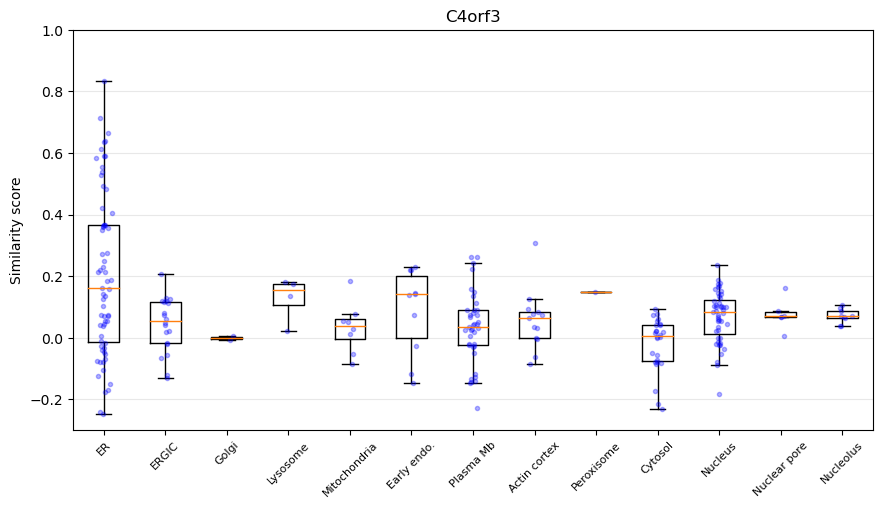

C4orf3 nearest genes:
 ANKRD46 | score: 0.85528443754386 | OC annot:  er 
 SEC61B | score: 0.8346703925797482 | OC annot:  er 
 EMC4 | score: 0.8129425298276458 | OC annot:  er 
 TMEM208 | score: 0.7985038902096805 | OC annot:  er 
 C4orf32 | score: 0.7244788230547076 | OC annot:  er 
 VMP1 | score: 0.7145194448778729 | OC annot:  er 
 ANKRD46 | score: 0.6729894714472429 | OC annot:  ORF 
 SGPL1 | score: 0.6655737949537373 | OC annot:  er 



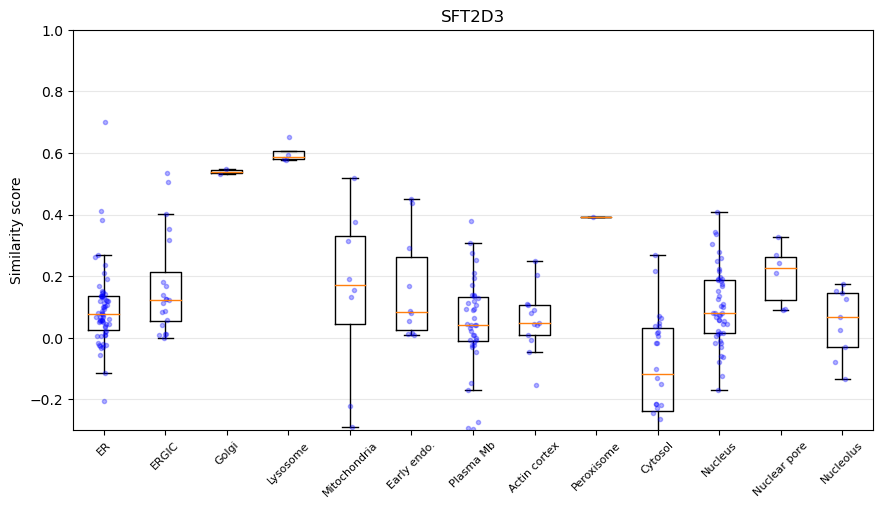

SFT2D3 nearest genes:
 SLC18B1 | score: 0.8091091212343262 | OC annot:  vesicles 
 SLC15A4 | score: 0.8018286378874911 | OC annot:  vesicles 
 SLC11A2 | score: 0.7814471744655007 | OC annot:  vesicles 
 SLC2A8 | score: 0.7727253084726915 | OC annot:  vesicles 
 TSPAN6 | score: 0.7660215011816969 | OC annot:  ORF 
 TMEM184C | score: 0.7496005611577852 | OC annot:  ORF 
 MCOLN1 | score: 0.7478471509701111 | OC annot:  vesicles 
 TSPAN3 | score: 0.7431436174959112 | OC annot:  ORF 



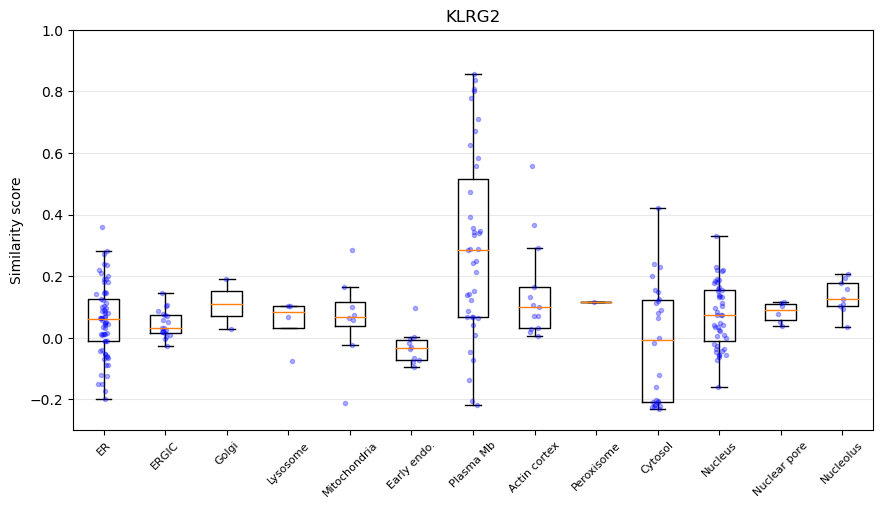

KLRG2 nearest genes:
 FARP1 | score: 0.8566747355247658 | OC annot:  membrane 
 IGF1R | score: 0.8362659286642267 | OC annot:  membrane 
 PIP5K1A | score: 0.8095142252377436 | OC annot:  membrane 
 ATP2B1 | score: 0.7999738265899824 | OC annot:  membrane 
 GOLGA7 | score: 0.7787551517239044 | OC annot:  membrane;vesicles 
 CMTM4 | score: 0.7716309134495088 | OC annot:  ORF 
 SLC26A6 | score: 0.7689333971026359 | OC annot:  membrane;vesicles 
 SLC16A10 | score: 0.7318396653999681 | OC annot:  vesicles;membrane 



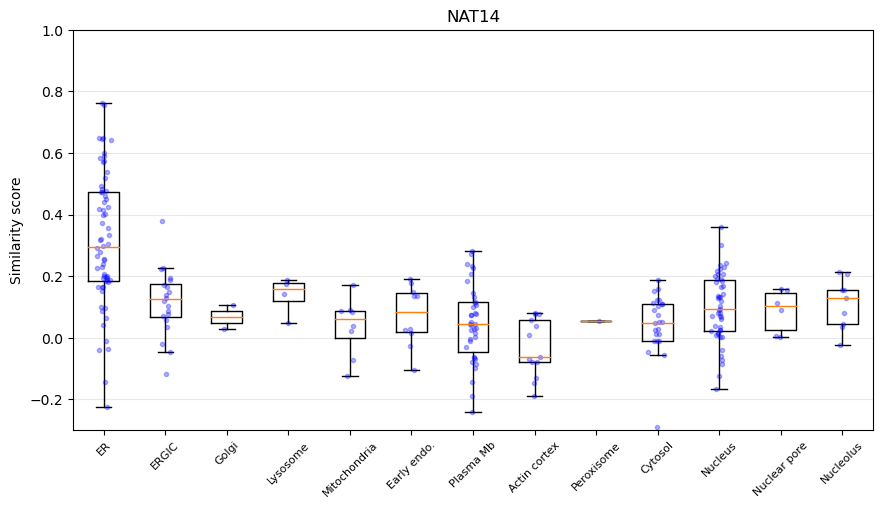

NAT14 nearest genes:
 ODR4 | score: 0.9485550177967019 | OC annot:  ORF 
 ANKRD46 | score: 0.9376207974297083 | OC annot:  ORF 
 STT3A | score: 0.761708777745892 | OC annot:  er 
 CERS5 | score: 0.7562490221382894 | OC annot:  er 
 C4orf32 | score: 0.7444794122964966 | OC annot:  er 
 CERS6 | score: 0.7375242954187154 | OC annot:  er 
 EMC8 | score: 0.6640271120808448 | OC annot:  er 
 TMEM208 | score: 0.6564940413917988 | OC annot:  er 



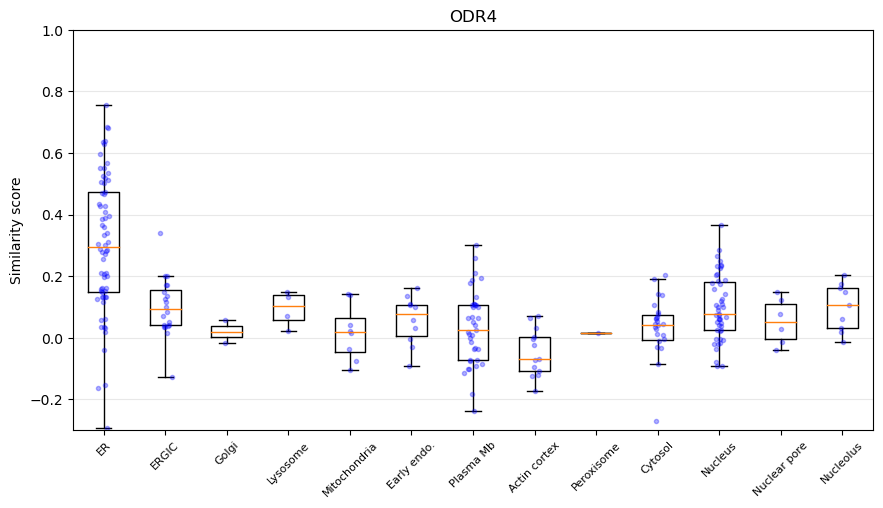

ODR4 nearest genes:
 NAT14 | score: 0.9485550177967019 | OC annot:  ORF 
 ANKRD46 | score: 0.8785008720094776 | OC annot:  ORF 
 CERS5 | score: 0.7548556899192701 | OC annot:  er 
 EMC9 | score: 0.7401232636415561 | OC annot:  er 
 CERS6 | score: 0.7035750216822043 | OC annot:  er 
 STT3A | score: 0.6856884715409837 | OC annot:  er 
 PKMYT1 | score: 0.6817598202487791 | OC annot:  er 
 CDS1 | score: 0.6765382279749946 | OC annot:  er 



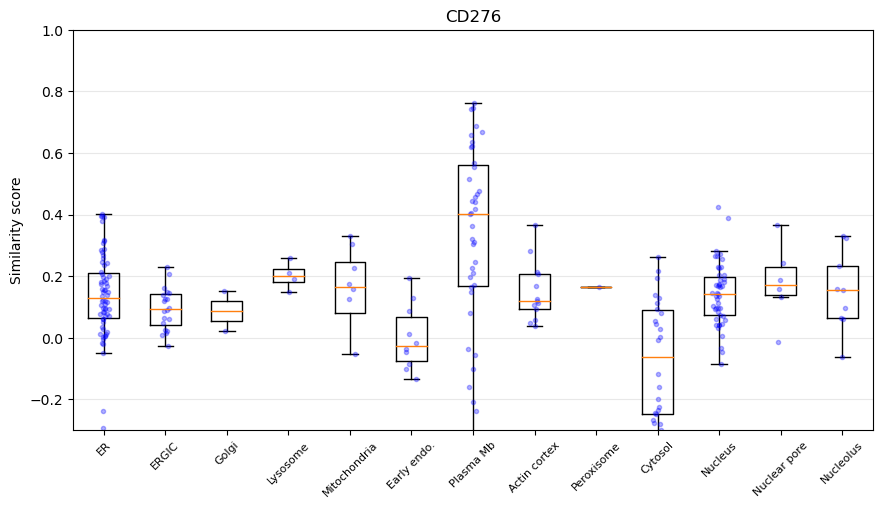

CD276 nearest genes:
 MYO1C | score: 0.9307604043463606 | OC annot:  membrane 
 CMTM4 | score: 0.8843862969148798 | OC annot:  ORF 
 SLC7A6 | score: 0.8605840950366981 | OC annot:  membrane;vesicles 
 SLC7A5 | score: 0.7616687950455953 | OC annot:  membrane;vesicles 
 MYO1B | score: 0.7461077558932052 | OC annot:  membrane 
 YES1 | score: 0.7414777828476453 | OC annot:  membrane 
 CD99 | score: 0.7227151039726161 | OC annot:  ORF 
 PTK7 | score: 0.7056346343969763 | OC annot:  membrane;vesicles 



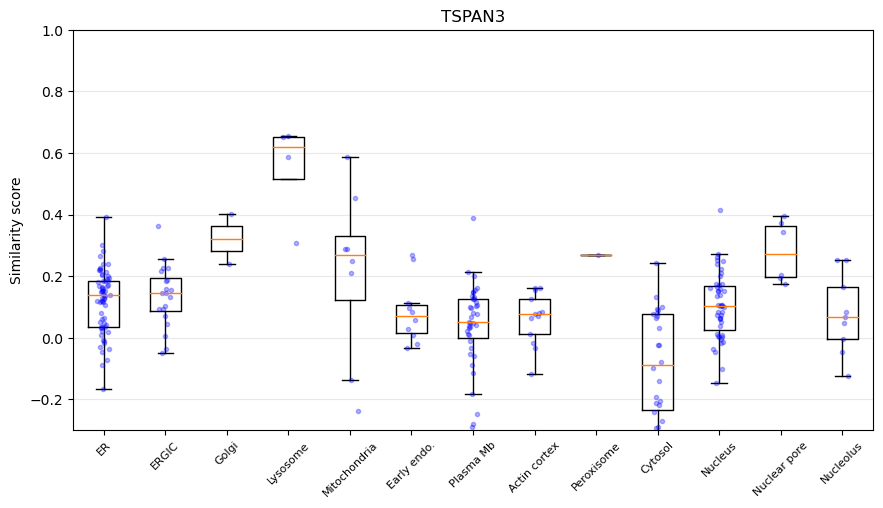

TSPAN3 nearest genes:
 TSPAN6 | score: 0.9170464622149193 | OC annot:  ORF 
 TMEM184C | score: 0.9163788197095625 | OC annot:  ORF 
 TPRA1 | score: 0.7522184246952881 | OC annot:  ORF 
 SFT2D3 | score: 0.7431436174959112 | OC annot:  ORF 
 SPNS1 | score: 0.6646362925026508 | OC annot:  vesicles 
 TMEM192 | score: 0.6553244294108607 | OC annot:  vesicles 
 LAMP2 | score: 0.6513651127670179 | OC annot:  vesicles 
 SLC15A4 | score: 0.635030731882582 | OC annot:  vesicles 



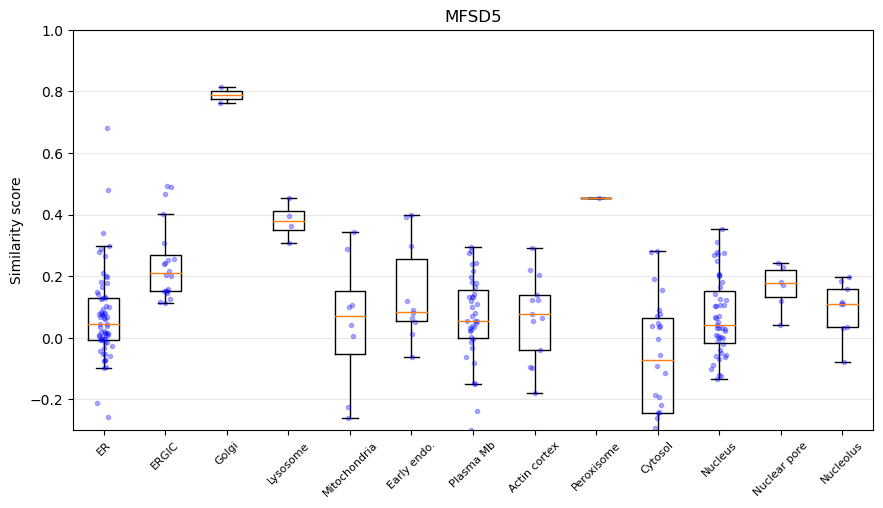

MFSD5 nearest genes:
 SLC37A4 | score: 0.8270945839044421 | OC annot:  golgi 
 SLC30A5 | score: 0.813938299815762 | OC annot:  golgi 
 SLC35E1 | score: 0.7611229129194087 | OC annot:  golgi 
 MAN1A2 | score: 0.7202094401998735 | OC annot:  vesicles 
 SFT2D3 | score: 0.7148642959526779 | OC annot:  ORF 
 TVP23C | score: 0.6879611346345407 | OC annot:  ORF 
 ELOVL1 | score: 0.6826969566786831 | OC annot:  vesicles 
 WWOX | score: 0.6823825519870121 | OC annot:  golgi 



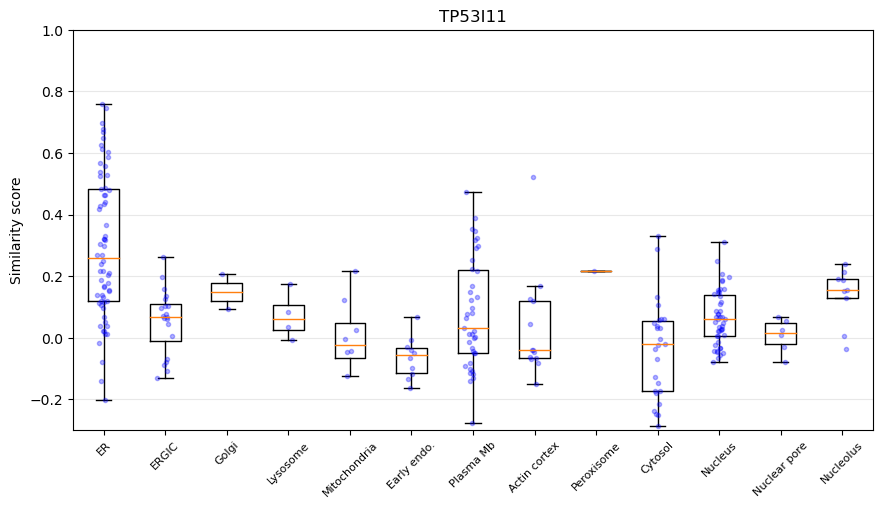

TP53I11 nearest genes:
 SMIM13 | score: 0.7872356097982389 | OC annot:  ORF 
 SLC27A4 | score: 0.7580054993928795 | OC annot:  er 
 PTDSS1 | score: 0.7457254612175913 | OC annot:  er 
 EMC10 | score: 0.7396668191323938 | OC annot:  er 
 SCD5 | score: 0.7292382944622691 | OC annot:  er 
 GPAT3 | score: 0.7004236050796163 | OC annot:  er 
 DHCR24 | score: 0.6984943296607511 | OC annot:  vesicles 
 ALG2 | score: 0.6846160527002724 | OC annot:  er 



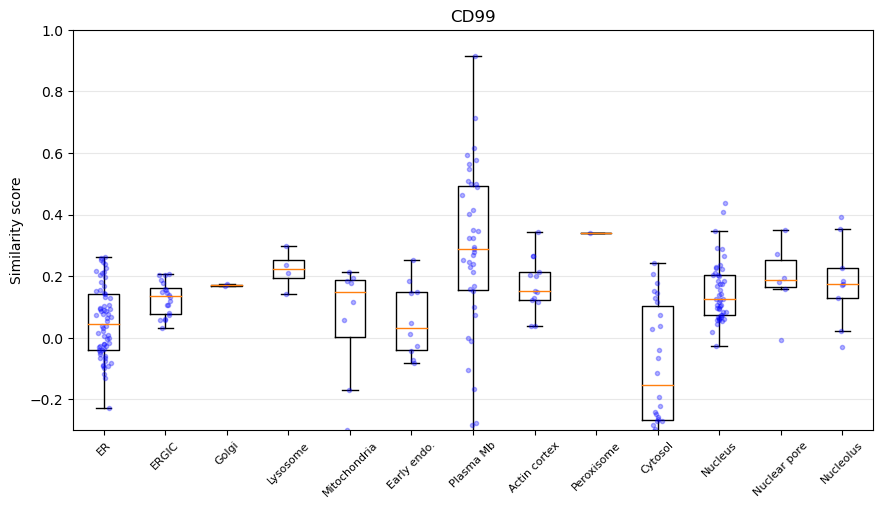

CD99 nearest genes:
 SLC16A1 | score: 0.916384076431277 | OC annot:  membrane;vesicles 
 MYO1C | score: 0.794511221680026 | OC annot:  membrane 
 CD276 | score: 0.7227151039726161 | OC annot:  ORF 
 SLC7A5 | score: 0.7140130841430596 | OC annot:  membrane;vesicles 
 MARK2 | score: 0.6900316500881274 | OC annot:  membrane;cytoplasmic 
 EZR | score: 0.6567665398491145 | OC annot:  membrane 
 TFRC | score: 0.6461195355796184 | OC annot:  membrane;vesicles 
 SLC1A5 | score: 0.6170747165261576 | OC annot:  membrane;vesicles 



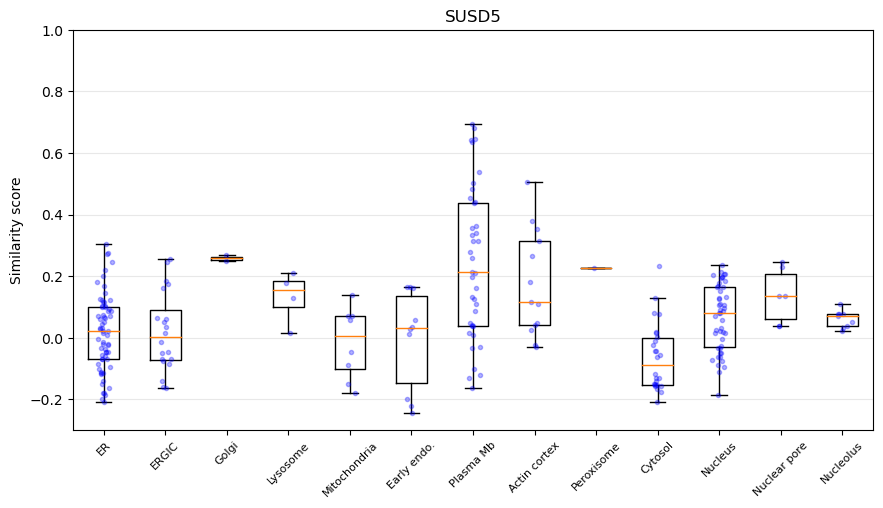

SUSD5 nearest genes:
 UTRN | score: 0.7242469499939785 | OC annot:  membrane 
 KIAA1522 | score: 0.704259016956014 | OC annot:  ORF 
 SLC44A2 | score: 0.6943505750400003 | OC annot:  membrane 
 FARP1 | score: 0.6810209582297198 | OC annot:  membrane 
 SLC23A2 | score: 0.6472279986830514 | OC annot:  membrane;vesicles 
 GOLGA7 | score: 0.6455619274331441 | OC annot:  membrane;vesicles 
 CD9 | score: 0.6428722351750686 | OC annot:  membrane;vesicles 
 SLC1A3 | score: 0.6392028450953957 | OC annot:  membrane;vesicles 



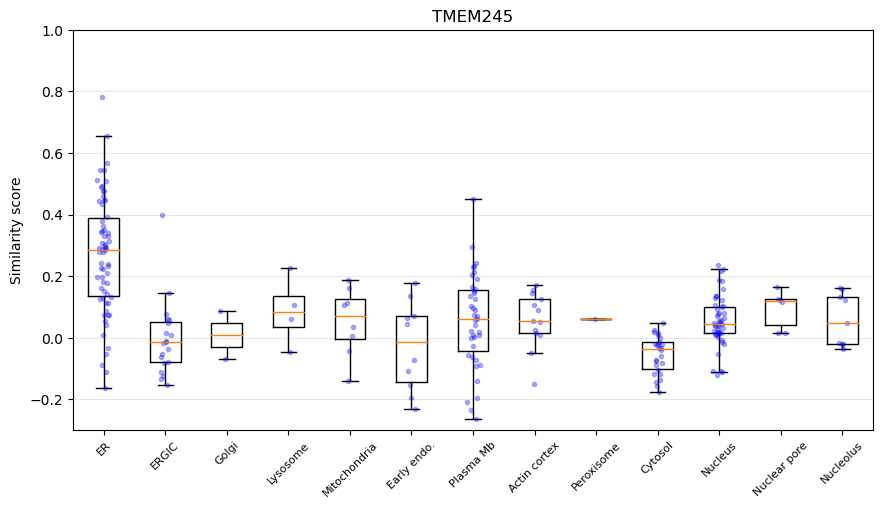

TMEM245 nearest genes:
 EMC1 | score: 0.782172540682746 | OC annot:  er 
 EMC3 | score: 0.7341954736326658 | OC annot:  er 
 MMGT1 | score: 0.7322330412215641 | OC annot:  er 
 SRPRB | score: 0.6558774117870102 | OC annot:  er 
 EMC10 | score: 0.6329191499248996 | OC annot:  er 
 REEP5 | score: 0.627543809942336 | OC annot:  er 
 STIM1 | score: 0.5672712014228136 | OC annot:  er 
 LNPK | score: 0.5450654438101074 | OC annot:  vesicles 



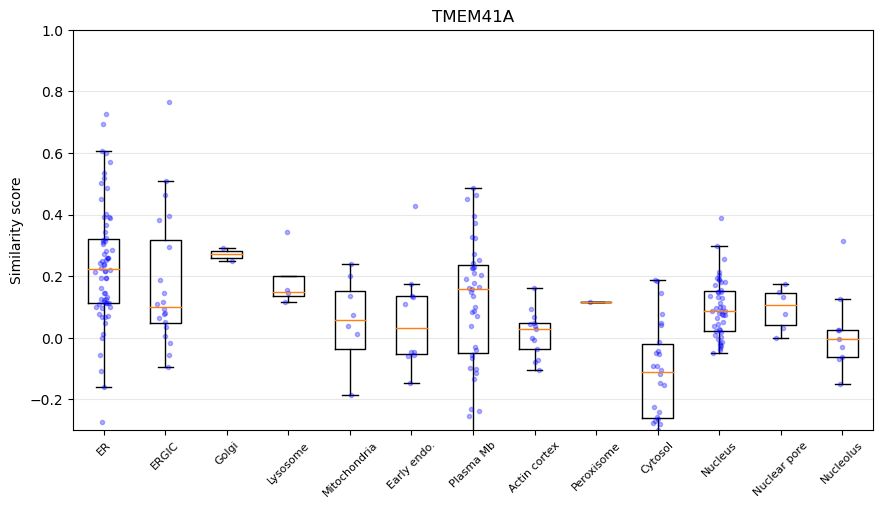

TMEM41A nearest genes:
 LMAN1 | score: 0.7646116364966192 | OC annot:  vesicles 
 SCD | score: 0.7259653584129308 | OC annot:  vesicles 
 RABL3 | score: 0.6963714148140795 | OC annot:  vesicles 
 ELOVL5 | score: 0.6928751680979759 | OC annot:  vesicles 
 ERG28 | score: 0.6653847568751026 | OC annot:  vesicles 
 STX10 | score: 0.640103880840701 | OC annot:  vesicles 
 SLC7A1 | score: 0.6153054712095866 | OC annot:  vesicles 
 well_H5_protein | score: 0.6083163722466514 | OC annot:  ORF 



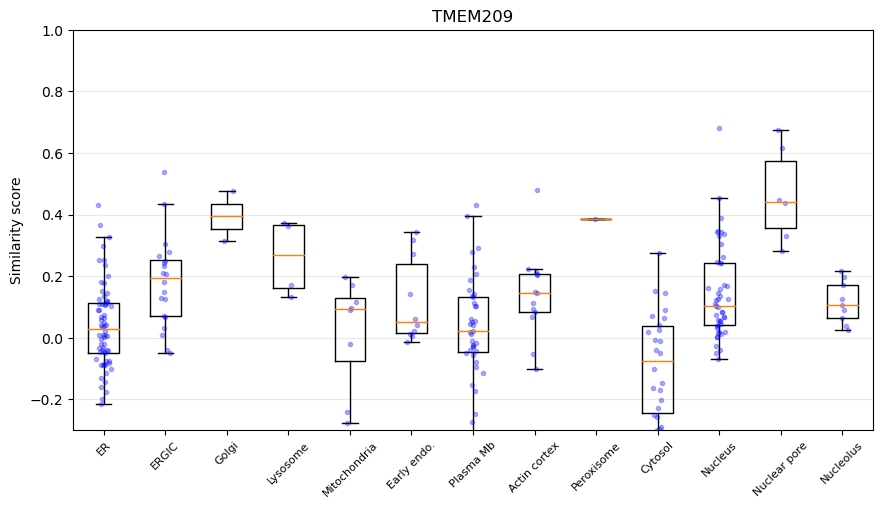

TMEM209 nearest genes:
 RANBP2 | score: 0.7162073609834287 | OC annot:  nuclear_membrane;big_aggregates 
 SYNE3 | score: 0.6822384859477664 | OC annot:  nuclear_membrane 
 NUP35 | score: 0.6746813603942349 | OC annot:  nuclear_membrane 
 NUP107 | score: 0.6168157343512022 | OC annot:  nuclear_membrane 
 COMTD1 | score: 0.5568857501392214 | OC annot:  ORF 
 KIAA1522 | score: 0.5518373263257675 | OC annot:  ORF 
 LEMD3 | score: 0.5518270876852913 | OC annot:  nuclear_membrane 
 SEC24D | score: 0.5393038813332391 | OC annot:  vesicles 



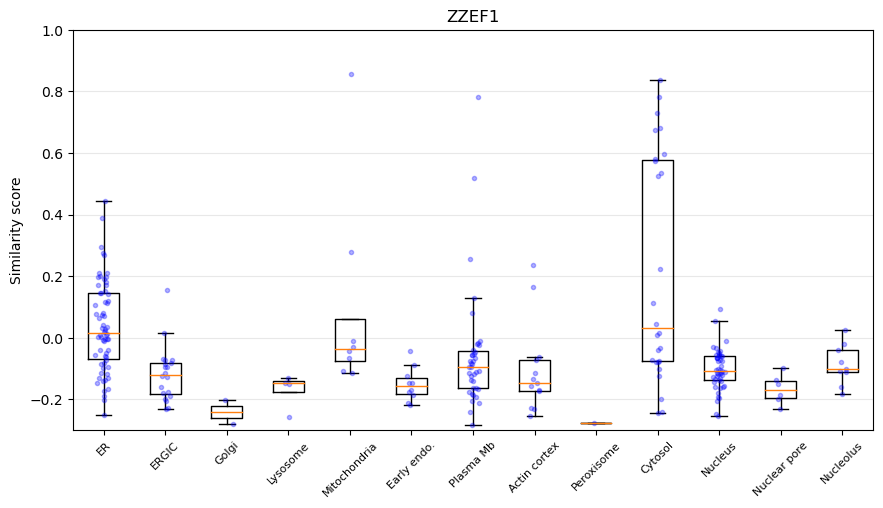

ZZEF1 nearest genes:
 ZNF598 | score: 0.9044098521546364 | OC annot:  cytoplasmic 
 AKAP13 | score: 0.9008194288146301 | OC annot:  cytoplasmic 
 AGO1 | score: 0.8825852470776903 | OC annot:  cytoplasmic 
 NEMF | score: 0.8807614583127528 | OC annot:  cytoplasmic 
 GRK2 | score: 0.8643492165817898 | OC annot:  cytoplasmic 
 PDPK1 | score: 0.8561953492352351 | OC annot:  cytoplasmic 
 DNM1 | score: 0.8549107337671303 | OC annot:  cytoplasmic 
 MYO9B | score: 0.8529307938328681 | OC annot:  cytoplasmic 



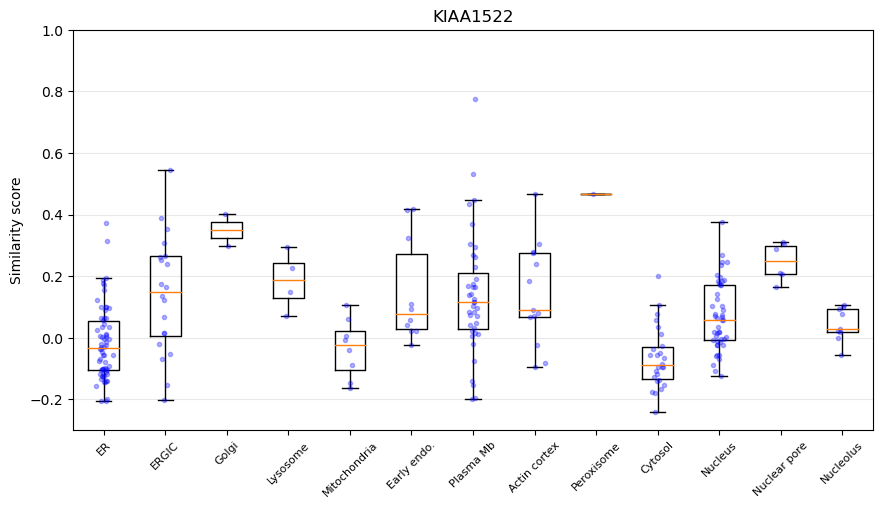

KIAA1522 nearest genes:
 SLC44A2 | score: 0.7770869424097445 | OC annot:  membrane 
 SEPTIN5 | score: 0.7164463172278682 | OC annot:  membrane 
 SUSD5 | score: 0.704259016956014 | OC annot:  ORF 
 PHLDB1 | score: 0.5752695424263902 | OC annot:  membrane 
 ITSN2 | score: 0.5734281822298031 | OC annot:  membrane;cell_contact 
 KIAA0319L | score: 0.5620153989318182 | OC annot:  vesicles 
 TVP23C | score: 0.554297678214488 | OC annot:  ORF 
 SLC35F2 | score: 0.5536365422170145 | OC annot:  ORF 



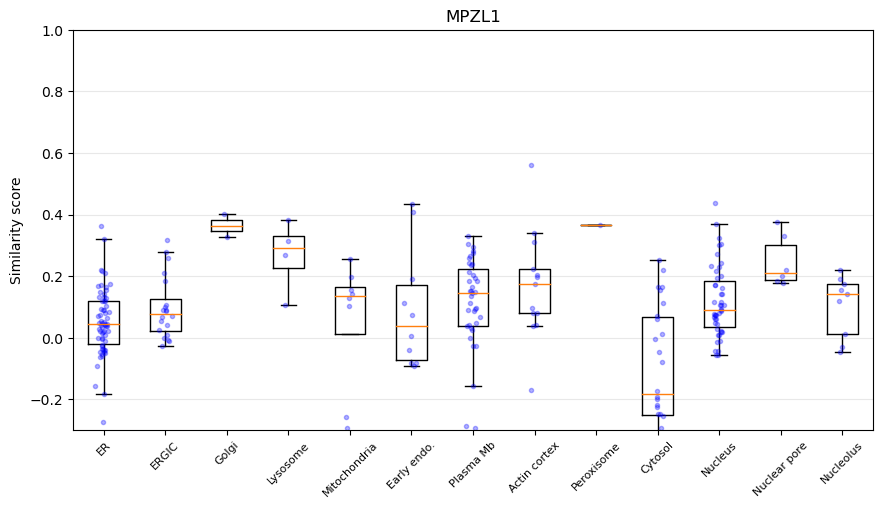

MPZL1 nearest genes:
 GJA1 | score: 0.8926439502851992 | OC annot:  cell_contact 
 PNPLA2 | score: 0.6332948144785123 | OC annot:  vesicles 
 DCP2 | score: 0.5789654418330679 | OC annot:  vesicles 
 TJP1 | score: 0.5608436673655813 | OC annot:  cell_contact 
 DCP1A | score: 0.5424217295833258 | OC annot:  vesicles 
 FTH1 | score: 0.5184367836485115 | OC annot:  vesicles 
 DDX6 | score: 0.4979397147270107 | OC annot:  big_aggregates 
 PHLDB1 | score: 0.4835976671929144 | OC annot:  membrane 



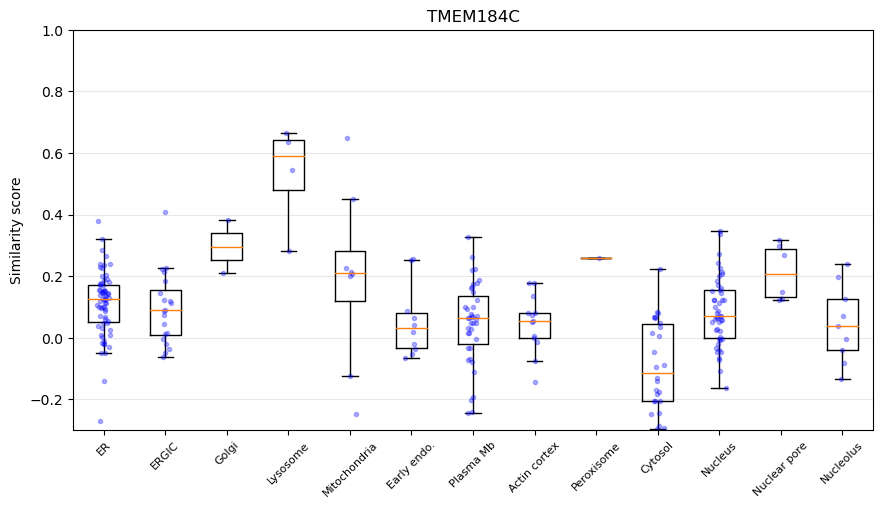

TMEM184C nearest genes:
 TSPAN3 | score: 0.9163788197095625 | OC annot:  ORF 
 TSPAN6 | score: 0.8939167853854877 | OC annot:  ORF 
 TPRA1 | score: 0.7953723868025155 | OC annot:  ORF 
 SFT2D3 | score: 0.7496005611577852 | OC annot:  ORF 
 SPNS1 | score: 0.6849853539525421 | OC annot:  vesicles 
 TMEM192 | score: 0.6665728679278552 | OC annot:  vesicles 
 DNAJC11 | score: 0.6492007562393566 | OC annot:  mitochondria 
 LAMP2 | score: 0.6343788840913568 | OC annot:  vesicles 



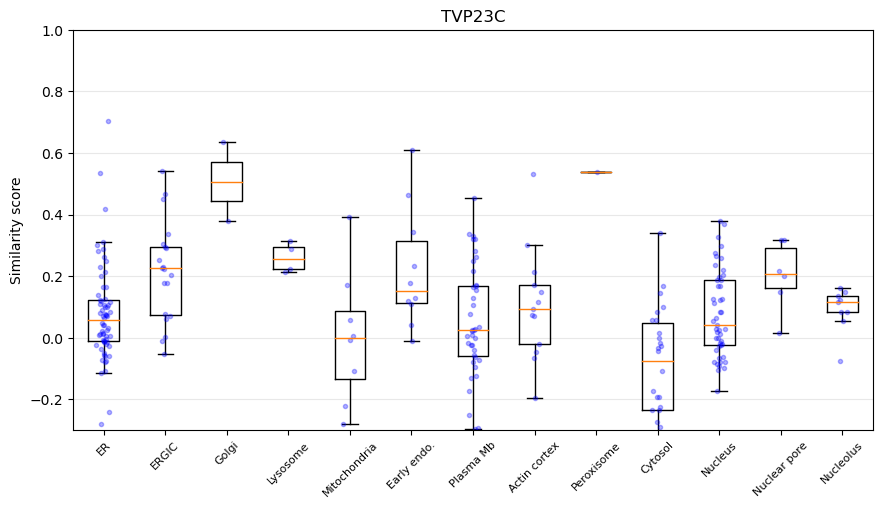

TVP23C nearest genes:
 MAN1A2 | score: 0.7337693715506618 | OC annot:  vesicles 
 COMTD1 | score: 0.7110155275219708 | OC annot:  ORF 
 ELOVL1 | score: 0.7049623438481825 | OC annot:  vesicles 
 COMMD2 | score: 0.6923458359538682 | OC annot:  vesicles 
 COMMD6 | score: 0.6884494789528093 | OC annot:  vesicles 
 MFSD5 | score: 0.6879611346345407 | OC annot:  ORF 
 PI4K2A | score: 0.6735303284798994 | OC annot:  vesicles 
 SC5D | score: 0.6719115617803798 | OC annot:  vesicles 



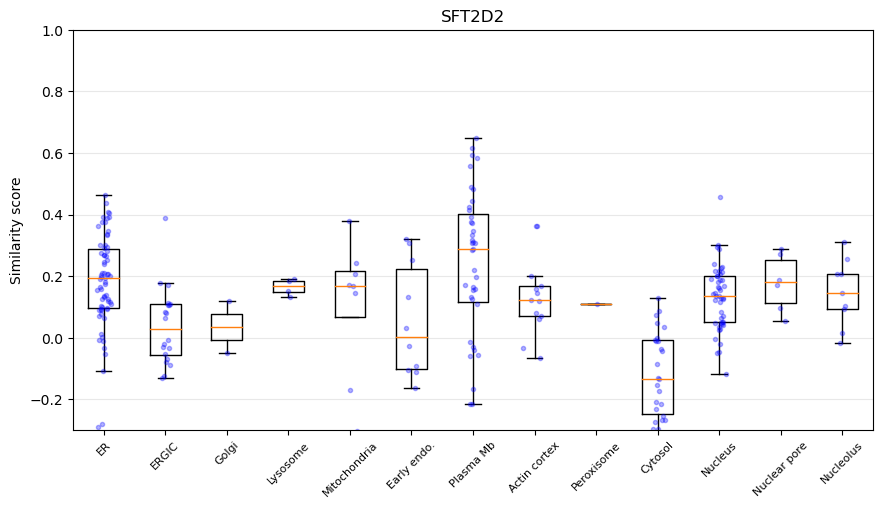

SFT2D2 nearest genes:
 SCAMP4 | score: 0.8542980447568638 | OC annot:  ORF 
 SLC16A2 | score: 0.755185503047515 | OC annot:  membrane;vesicles 
 VAMP3 | score: 0.724145375572953 | OC annot:  membrane;vesicles 
 SLC7A6 | score: 0.7008783611901465 | OC annot:  membrane;vesicles 
 SLC46A1 | score: 0.6546661760505301 | OC annot:  membrane;vesicles 
 SLC1A5 | score: 0.6496341177953022 | OC annot:  membrane;vesicles 
 SCAMP4 | score: 0.6435447078294111 | OC annot:  vesicles;membrane 
 CD276 | score: 0.6205277677147549 | OC annot:  ORF 



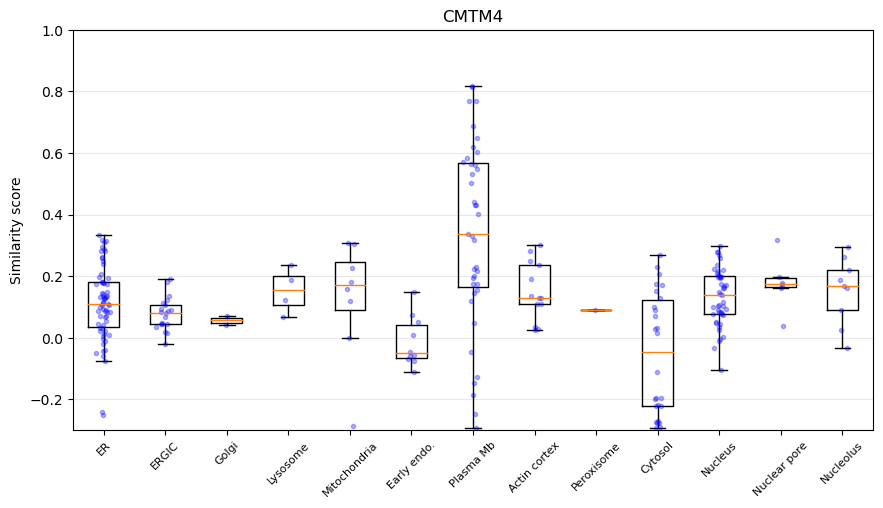

CMTM4 nearest genes:
 CD276 | score: 0.8843862969148798 | OC annot:  ORF 
 YES1 | score: 0.8184243527501599 | OC annot:  membrane 
 PIP5K1A | score: 0.8129703008229727 | OC annot:  membrane 
 SLC7A6 | score: 0.7792560468672773 | OC annot:  membrane;vesicles 
 KLRG2 | score: 0.7716309134495088 | OC annot:  ORF 
 SLC5A6 | score: 0.7697986541370735 | OC annot:  membrane;vesicles 
 ATP2B1 | score: 0.7690910343349567 | OC annot:  membrane 
 MYO1C | score: 0.7367052606401117 | OC annot:  membrane 



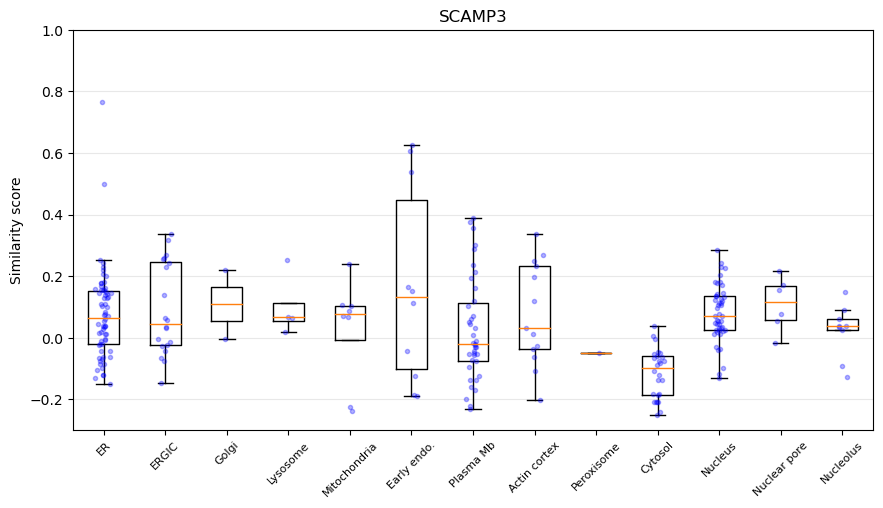

SCAMP3 nearest genes:
 VTI1A | score: 0.8058870791559639 | OC annot:  vesicles 
 ATP6AP1 | score: 0.774333698038128 | OC annot:  vesicles 
 ATP6AP2 | score: 0.764188056747871 | OC annot:  vesicles 
 STX12 | score: 0.7006159249263502 | OC annot:  vesicles 
 AGTRAP | score: 0.6526921229528642 | OC annot:  vesicles;golgi 
 ATP6V0A1 | score: 0.6501872036251085 | OC annot:  vesicles 
 VAMP2 | score: 0.6464713738467239 | OC annot:  membrane;vesicles 
 VAMP8 | score: 0.6422138590919367 | OC annot:  vesicles 



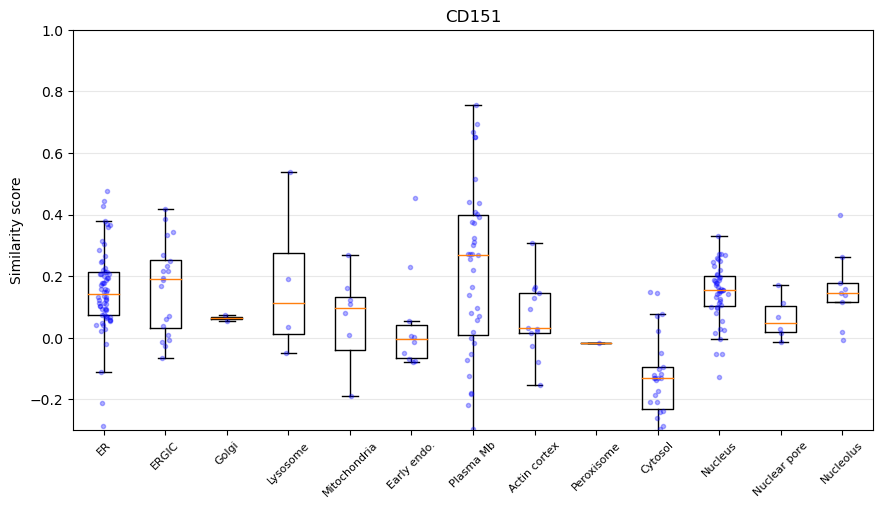

CD151 nearest genes:
 PIP4P1 | score: 0.7854568528778665 | OC annot:  vesicles 
 SLC2A1 | score: 0.7545506212488908 | OC annot:  vesicles 
 SLC16A2 | score: 0.7247093301663649 | OC annot:  membrane;vesicles 
 HLA-A | score: 0.6944801871162429 | OC annot:  membrane;vesicles 
 SLC1A5 | score: 0.6692968173553022 | OC annot:  membrane;vesicles 
 TFRC | score: 0.6649911873852573 | OC annot:  membrane;vesicles 
 ATP1A1 | score: 0.6528571579951367 | OC annot:  vesicles 
 CD151 | score: 0.6517011517368207 | OC annot:  membrane;vesicles 



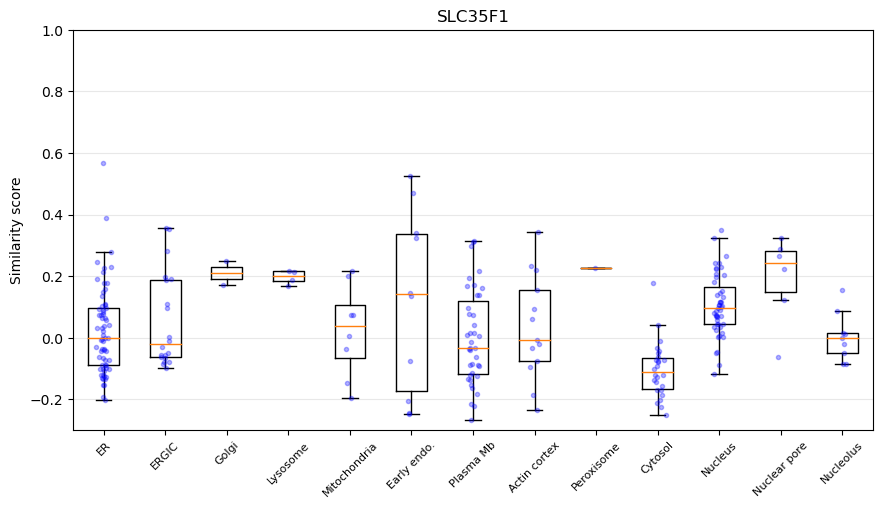

SLC35F1 nearest genes:
 SLC35F2 | score: 0.8122641976225794 | OC annot:  ORF 
 SLC35F2 | score: 0.7020967320868265 | OC annot:  vesicles 
 KIAA0319L | score: 0.6504153516897591 | OC annot:  vesicles 
 LNPK | score: 0.5678767022629629 | OC annot:  vesicles 
 ATG9A | score: 0.5287882653546235 | OC annot:  vesicles 
 SCAMP1 | score: 0.5254696579488072 | OC annot:  golgi;vesicles 
 SCAMP3 | score: 0.5190250874728677 | OC annot:  ORF 
 ATP6V0D1 | score: 0.5188225946134251 | OC annot:  vesicles 



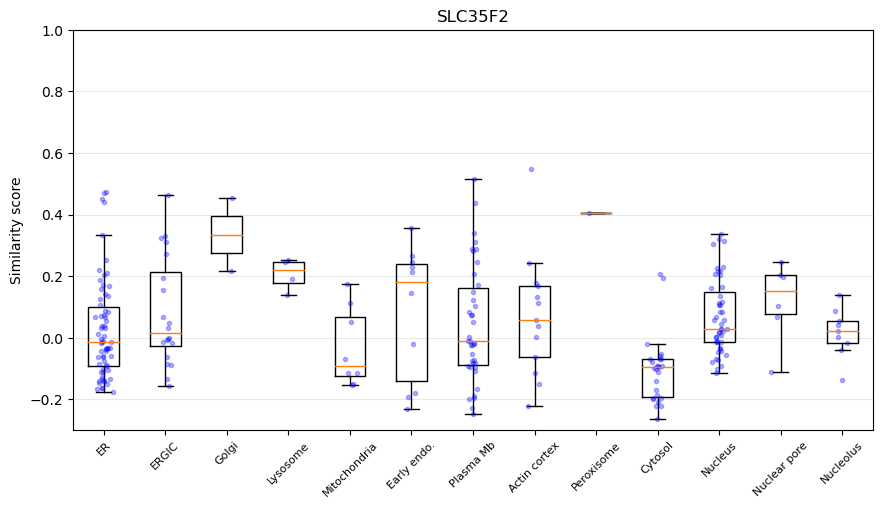

SLC35F2 nearest genes:
 KIAA0319L | score: 0.8637431662566397 | OC annot:  vesicles 
 SLC35F1 | score: 0.8122641976225794 | OC annot:  ORF 
 TMEM87A | score: 0.6595041691336665 | OC annot:  vesicles;golgi 
 CMTM7 | score: 0.6351929921072356 | OC annot:  ORF 
 TVP23C | score: 0.6259600230564497 | OC annot:  ORF 
 pML545 | score: 0.620334736382858 | OC annot:  ORF 
 NUF2 | score: 0.5941440471960097 | OC annot:  cytoskeleton 
 PI4K2A | score: 0.5647546702837197 | OC annot:  vesicles 



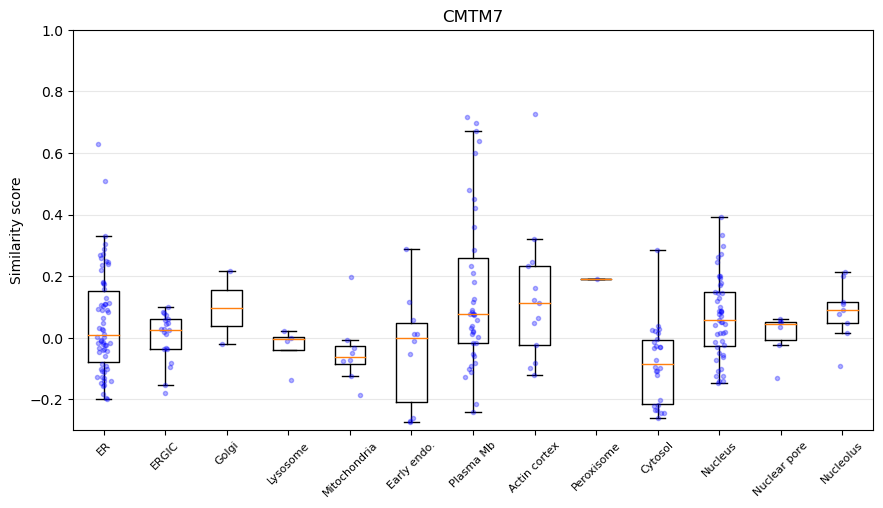

CMTM7 nearest genes:
 pML545 | score: 0.8414962629751966 | OC annot:  ORF 
 SLC16A10 | score: 0.816229044173187 | OC annot:  vesicles;membrane 
 SLC4A2 | score: 0.7716173956040394 | OC annot:  membrane 
 SVIL | score: 0.7283770664925101 | OC annot:  membrane 
 IGF1R | score: 0.7181668802221329 | OC annot:  membrane 
 SLC26A6 | score: 0.7140500697450235 | OC annot:  membrane;vesicles 
 ORAI1 | score: 0.6969858324561907 | OC annot:  membrane 
 NUF2 | score: 0.6820441150183214 | OC annot:  cytoskeleton 



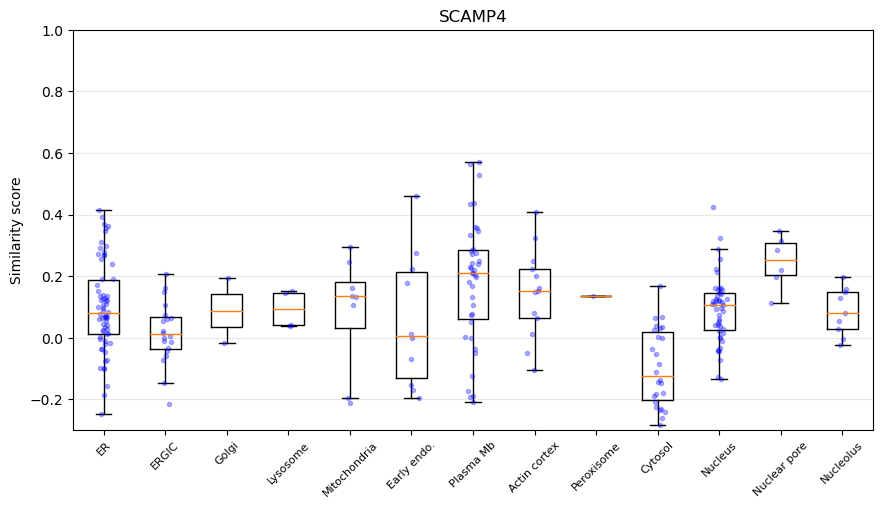

SCAMP4 nearest genes:
 SFT2D2 | score: 0.8542980447568638 | OC annot:  ORF 
 SCAMP4 | score: 0.8455050843898695 | OC annot:  vesicles;membrane 
 VAMP3 | score: 0.7431641456285305 | OC annot:  membrane;vesicles 
 ESYT1 | score: 0.6795592783584903 | OC annot:  membrane;er 
 VAMP2 | score: 0.647023136246985 | OC annot:  membrane;vesicles 
 SLC16A2 | score: 0.5781865071383153 | OC annot:  membrane;vesicles 
 SLC1A5 | score: 0.572310421409287 | OC annot:  membrane;vesicles 
 MYO1B | score: 0.5654959762369448 | OC annot:  membrane 



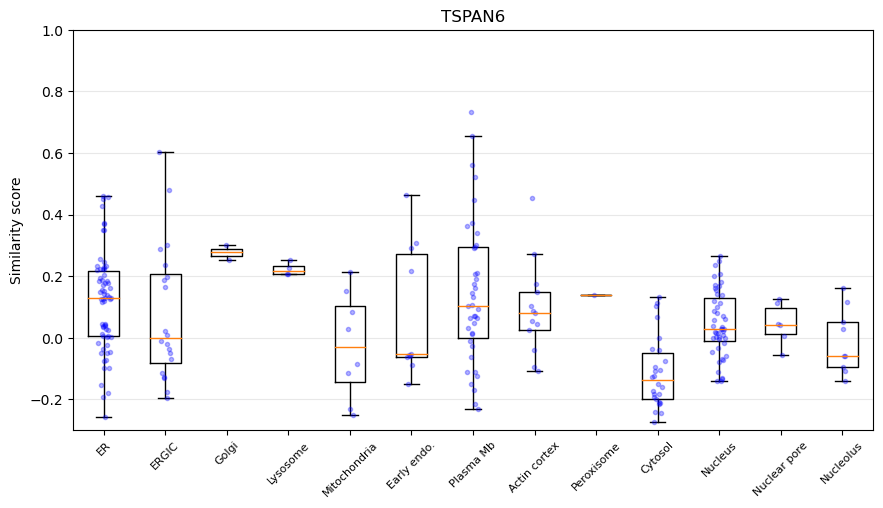

TSPAN6 nearest genes:
 CD81 | score: 0.7326389659751747 | OC annot:  membrane;vesicles 
 SPG21 | score: 0.7168265934345555 | OC annot:  vesicles 
 CD9 | score: 0.6561401240835337 | OC annot:  membrane;vesicles 
 TMEM41A | score: 0.6083163722466514 | OC annot:  ORF 
 LMAN1 | score: 0.6022832368476057 | OC annot:  vesicles 
 SLC19A1 | score: 0.5814683838536313 | OC annot:  membrane;vesicles 
 RABL3 | score: 0.5709538021836296 | OC annot:  vesicles 
 CD151 | score: 0.5594402618124354 | OC annot:  membrane;vesicles 



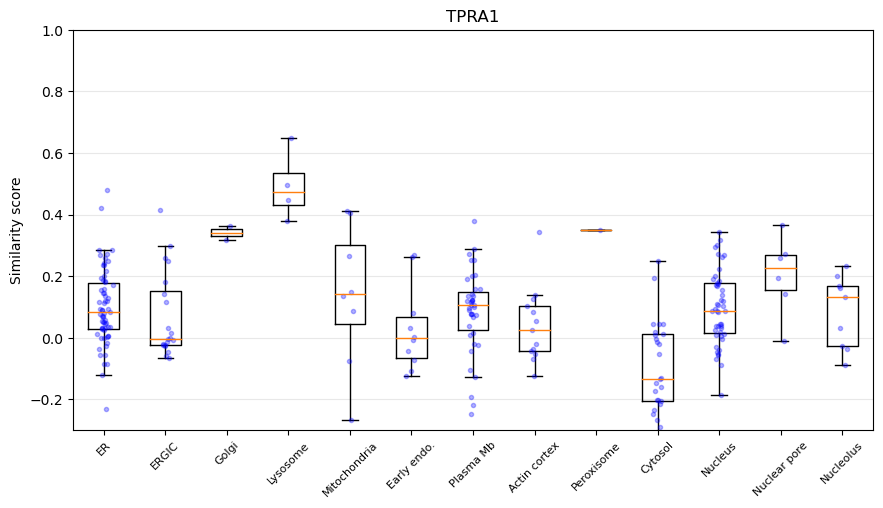

TPRA1 nearest genes:
 TMEM184C | score: 0.7953723868025155 | OC annot:  ORF 
 CLCN7 | score: 0.7585604936859593 | OC annot:  vesicles 
 TSPAN3 | score: 0.7522184246952881 | OC annot:  ORF 
 SFT2D3 | score: 0.736427743258703 | OC annot:  ORF 
 MCOLN1 | score: 0.7238928893420639 | OC annot:  vesicles 
 TSPAN6 | score: 0.7128011173713963 | OC annot:  ORF 
 SPNS1 | score: 0.7056238145434247 | OC annot:  vesicles 
 SLC11A2 | score: 0.7026920191482058 | OC annot:  vesicles 



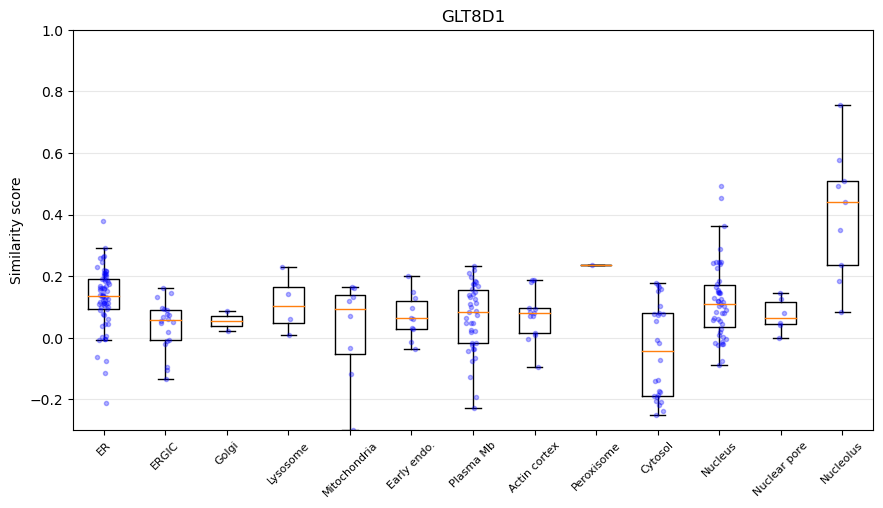

GLT8D1 nearest genes:
 GNL3 | score: 0.7570999762176368 | OC annot:  nucleolus_gc 
 RRP1 | score: 0.6249678283168596 | OC annot:  nucleolus_gc 
 NPM3 | score: 0.5765090089101162 | OC annot:  nucleolus_gc 
 FBL | score: 0.5610833174981389 | OC annot:  nucleolus_fc_dfc 
 NPM1 | score: 0.5083272506609682 | OC annot:  nucleolus_gc 
 NOL10 | score: 0.4920334264575916 | OC annot:  nucleolus_gc 
 MYBBP1A | score: 0.4550657782223265 | OC annot:  nucleolus_gc 
 PES1 | score: 0.45462583451046545 | OC annot:  nucleolus_gc 



In [10]:
# for orphan protein, find its similarity score to reference organelle marker and output plot; also output nearest genes by distance, their scores, and OpenCell annotation
# output new dict with aggregate quantification of similarity scores

agg_similarity_score = pd.DataFrame()

for goi in orphans:
    df_goi = similarity_scores_df[goi]

    org_scores = {
    'ER': er_markers_in_OC[goi],
    'ERGIC': ergic_markers_in_OC[goi],
    'Golgi': golgi_markers_in_OC[goi],
    'Lysosome': lyso_markers_in_OC[goi],
    'Mitochondria': mito_markers_in_OC[goi],
    'Early endo.': ee_markers_in_OC[goi],
    'Plasma Mb': pm_markers_in_OC[goi],
    'Actin cortex': actin_markers_in_OC[goi],
    'Peroxisome': perox_markers_in_OC[goi],
    'Cytosol': cytosol_markers_in_OC[goi],
    'Nucleus': nucleus_markers_in_OC[goi],
    'Nuclear pore': nuclear_pore_markers_in_OC[goi],
    'Nucleolus': nucleolus_markers_in_OC[goi]
    }

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.boxplot(org_scores.values(), showfliers=False)

    for count, dict_key in enumerate(org_scores):
        y = org_scores[dict_key]
        x = np.random.normal(count + 1, 0.05, size=len(y))
        plt.plot(x, y, 'b.', alpha=0.3)

        # get whisker boundaries
        box_median = np.median(y)
        upper_quartile = np.percentile(y, 75)
        lower_quartile = np.percentile(y, 25)

        iqr = upper_quartile - lower_quartile
        upper_whisker = y[y<=upper_quartile+1.5*iqr].max()
        lower_whisker = y[y>=lower_quartile-1.5*iqr].min()
        # build dict
        agg_similarity_score.loc[goi, dict_key] = upper_whisker

        

    ax.set_xticklabels(list(org_scores.keys()),
                        rotation=45, fontsize=8)

    ax.set_ylim(-0.3, 1)
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    plt.title(goi)
    plt.ylabel('Similarity score')
    plt.show()

    print(goi, 'nearest genes:\n', 
          knn_num_df[goi].prot_nn0, '| score:', knn_num_df[goi].dist0, '| OC annot: ', knn_num_df[goi].loc_grade1_nn0, '\n',
          knn_num_df[goi].prot_nn1, '| score:', knn_num_df[goi].dist1, '| OC annot: ', knn_num_df[goi].loc_grade1_nn1, '\n',
          knn_num_df[goi].prot_nn2, '| score:', knn_num_df[goi].dist2, '| OC annot: ', knn_num_df[goi].loc_grade1_nn2, '\n',
          knn_num_df[goi].prot_nn3, '| score:', knn_num_df[goi].dist3, '| OC annot: ', knn_num_df[goi].loc_grade1_nn3, '\n',
          knn_num_df[goi].prot_nn4, '| score:', knn_num_df[goi].dist4, '| OC annot: ', knn_num_df[goi].loc_grade1_nn4, '\n',
          knn_num_df[goi].prot_nn5, '| score:', knn_num_df[goi].dist5, '| OC annot: ', knn_num_df[goi].loc_grade1_nn5, '\n',
          knn_num_df[goi].prot_nn6, '| score:', knn_num_df[goi].dist6, '| OC annot: ', knn_num_df[goi].loc_grade1_nn6, '\n',
          knn_num_df[goi].prot_nn7, '| score:', knn_num_df[goi].dist7, '| OC annot: ', knn_num_df[goi].loc_grade1_nn7, '\n')

In [11]:
# save the top similarity score vs each organelle for each orphan protein

agg_similarity_score.to_csv("aggregate_similarity_score.csv")
agg_similarity_score.head()

,ER,ERGIC,Golgi,Lysosome,Mitochondria,Early endo.,Plasma Mb,Actin cortex,Peroxisome,Cytosol,Nucleus,Nuclear pore,Nucleolus
ANKRD46,0.747304,0.173378,0.051668,0.182098,0.093900,0.200116,0.315142,0.146927,0.030535,0.169781,0.344681,0.153834,0.154763
C4orf3,0.834670,0.206441,0.005663,0.181627,0.076957,0.230520,0.241411,0.125647,0.147410,0.091733,0.236937,0.087689,0.106372
SFT2D3,0.269824,0.401462,0.547872,0.592248,0.518371,0.449923,0.307744,0.247636,0.392976,0.267983,0.408026,0.328157,0.174303
KLRG2,0.280478,0.144493,0.191057,0.104189,0.164304,0.000889,0.856675,0.290900,0.116436,0.420896,0.330042,0.116342,0.205313
NAT14,0.761709,0.227532,0.106134,0.187553,0.169902,0.189393,0.280496,0.078717,0.052603,0.185715,0.359384,0.157494,0.213015


In [12]:
# set orphans in the same order as Figure 4

list_order = ['ANKRD46',
 'C4orf3',
 'NAT14',
 'ODR4',
 'TMEM245',
 'TMEM41A',
 'TP53I11',
 'ZZEF1',
 'CD151',
 'CD99',
 'SFT2D2',
 'CD276',
 'KLRG2',
 'SUSD5',
 'TMEM184C',
 'TSPAN3',
 'MFSD5',
 'TVP23C',
 'SCAMP3',
 'TSPAN6',
 'TMEM209',
 'CMTM4',
 'CMTM7',
 'SCAMP4',
 'SLC35F1',
 'SLC35F2',
 'SFT2D3',
 'KIAA1522',
 'MPZL1',
 'TPRA1',
 'GLT8D1']

# re-index scoring matrix

agg_similarity_score_sorted = agg_similarity_score.reindex(list_order)
agg_similarity_score_sorted.head()

,ER,ERGIC,Golgi,Lysosome,Mitochondria,Early endo.,Plasma Mb,Actin cortex,Peroxisome,Cytosol,Nucleus,Nuclear pore,Nucleolus
ANKRD46,0.747304,0.173378,0.051668,0.182098,0.093900,0.200116,0.315142,0.146927,0.030535,0.169781,0.344681,0.153834,0.154763
C4orf3,0.834670,0.206441,0.005663,0.181627,0.076957,0.230520,0.241411,0.125647,0.147410,0.091733,0.236937,0.087689,0.106372
NAT14,0.761709,0.227532,0.106134,0.187553,0.169902,0.189393,0.280496,0.078717,0.052603,0.185715,0.359384,0.157494,0.213015
ODR4,0.754856,0.200365,0.056016,0.148205,0.141863,0.161949,0.299626,0.070390,0.015160,0.189320,0.367383,0.147921,0.204652
TMEM245,0.655877,0.143660,0.086273,0.226177,0.188518,0.175953,0.450409,0.169868,0.061370,0.046600,0.223606,0.162987,0.162854


<AxesSubplot:>

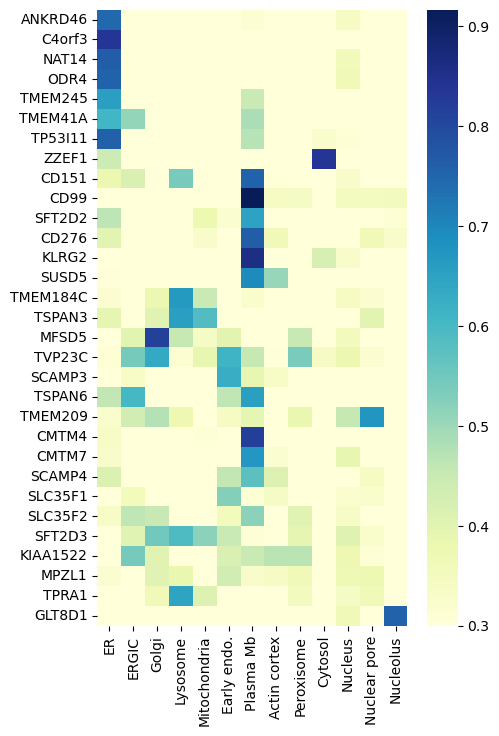

In [13]:
# plot similarity score heatmap for each orphan

plt.figure(figsize=(5,8))
sns.heatmap(data=agg_similarity_score_sorted, cmap="YlGnBu", vmin=0.3)

In [14]:
# threshold similarity score heatmap keeping only scores >= 0.6

agg_similarity_score_sorted_threshold_0p6 = agg_similarity_score_sorted
agg_similarity_score_sorted_threshold_0p6[agg_similarity_score_sorted_threshold_0p6 < 0.6] = 0
agg_similarity_score_sorted_threshold_0p6.head()

,ER,ERGIC,Golgi,Lysosome,Mitochondria,Early endo.,Plasma Mb,Actin cortex,Peroxisome,Cytosol,Nucleus,Nuclear pore,Nucleolus
ANKRD46,0.747304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C4orf3,0.834670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NAT14,0.761709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ODR4,0.754856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TMEM245,0.655877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


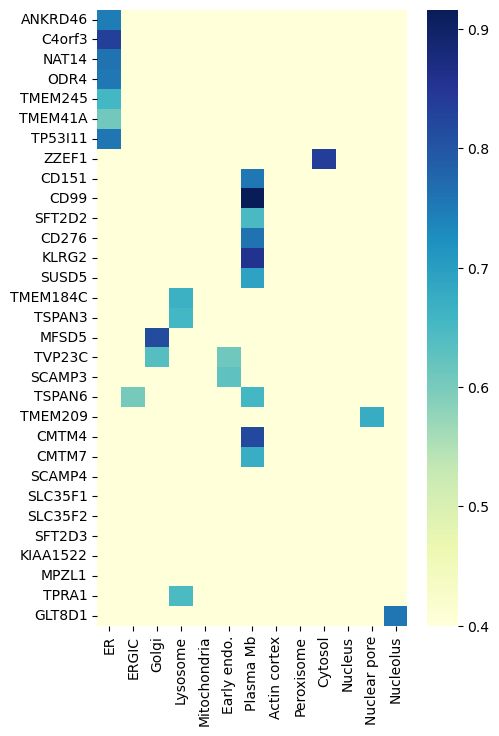

In [15]:
# plot thresholded heatmap and save PDF for Suppl Figure S6C

plt.figure(figsize=(5,8))
sns.heatmap(data=agg_similarity_score_sorted_threshold_0p6, cmap="YlGnBu", vmin=0.4)
plt.savefig("Suppl_Figure_S6C_cytoself_scores_heatmap.pdf")

